In [ ]:
#!pip install hmmlearn ruptures seaborn

  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
Using cached seaborn-0.13.2-py3-none-any.whl (294 kB)


In [23]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
import ruptures as rpt
from scipy.stats import skew, kurtosis
import seaborn as sns

# 1. Data Importation and Cleaning

/var/folders/3_/t8l3yh8s28z9_jbq7gqy7byr0000gn/T/ipykernel_9791/3759571879.py:5: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed


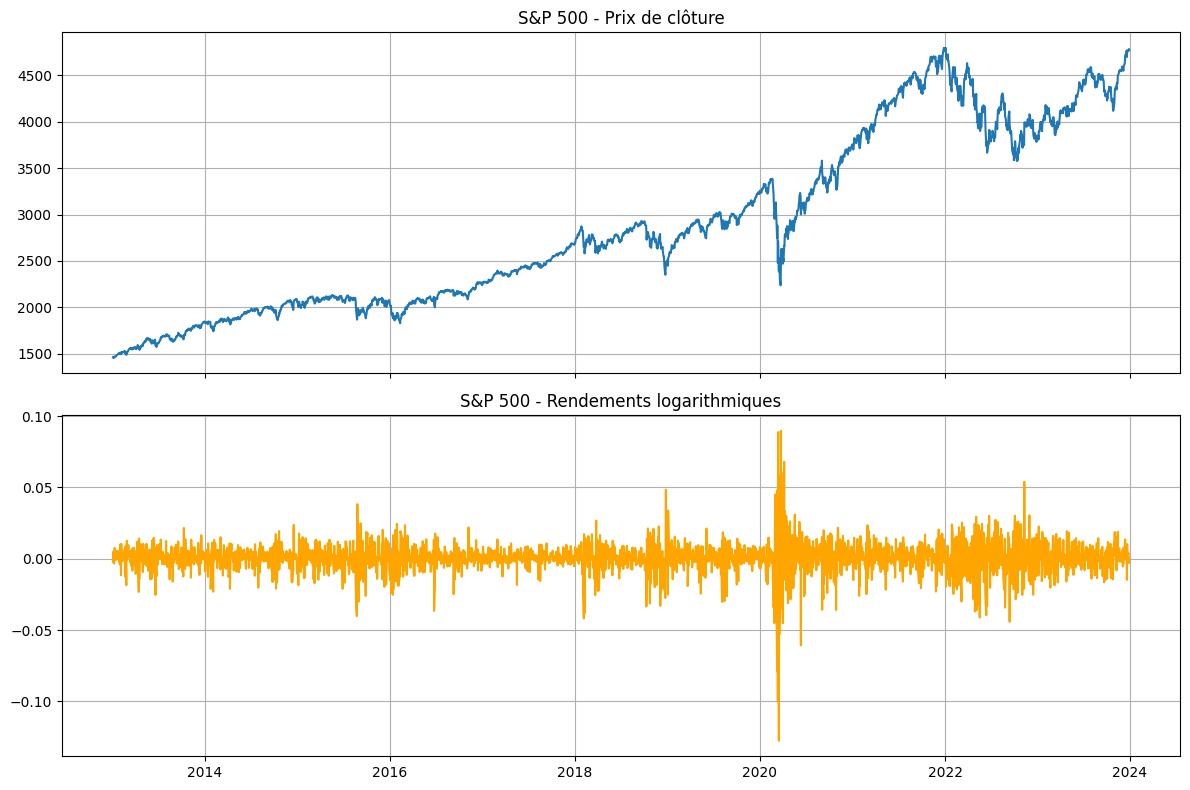

In [2]:
ticker = "^GSPC"  # S&P 500 index
start_date = "2013-01-01"
end_date = "2023-12-31"

data = yf.download(ticker, start=start_date, end=end_date)

data = data[["Close"]].rename(columns={"Close": "price"})
data.dropna(inplace=True)

data["log_return"] = np.log(data["price"] / data["price"].shift(1))
data.dropna(inplace=True)

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

ax1.plot(data.index, data["price"], label="S&P 500 Price")
ax1.set_title("S&P 500 - Prix de clôture")
ax1.grid(True)

ax2.plot(data.index, data["log_return"], color="orange", label="Log-return")
ax2.set_title("S&P 500 - Rendements logarithmiques")
ax2.grid(True)

plt.tight_layout()
plt.show()


# 2. Training of a Hidden Markov Model using HMMlearn

We set 3 hidden states <br>
.fit uses the E-M algorithm to find the transition probas and emission probas <br>
.predict uses the Viterbi algorithm to find the most probable sequence of hidden states, knowning the emissions

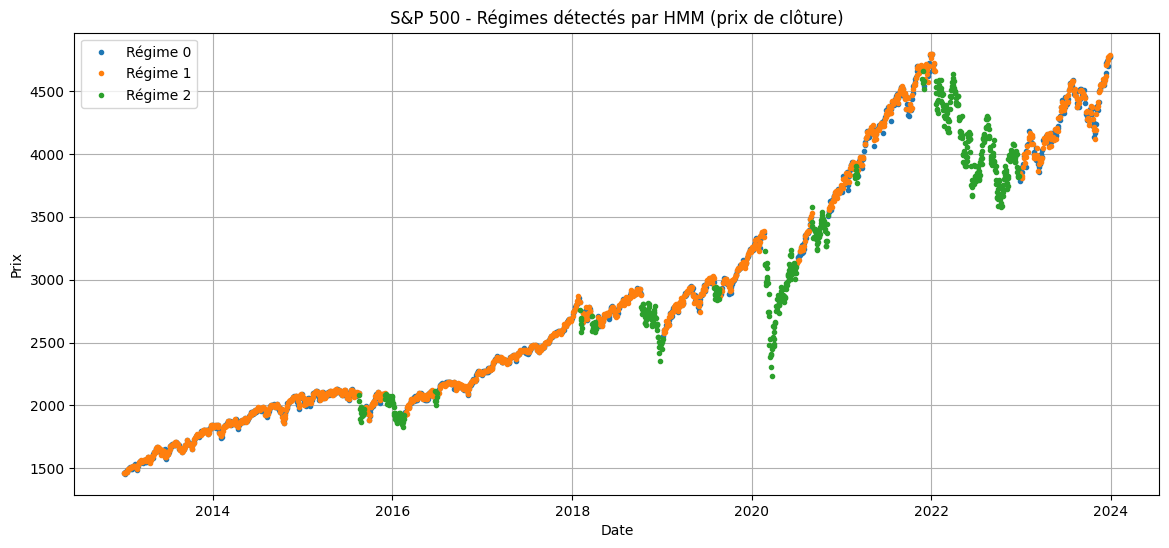

In [5]:
# hmmlearn attend un tableau 2D : (n_samples, n_features)
returns = data["log_return"].values.reshape(-1, 1)
n_states = 3

model = GaussianHMM(n_components=n_states, covariance_type="full", n_iter=1000, random_state=42)
model.fit(returns)

hidden_states = model.predict(returns)
data["regime"] = hidden_states

plt.figure(figsize=(14, 6))

for i in range(n_states):
    state = data[data["regime"] == i]
    plt.plot(state.index, state["price"], ".", label=f"Régime {i}")

plt.title("S&P 500 - Régimes détectés par HMM (prix de clôture)")
plt.xlabel("Date")
plt.ylabel("Prix")
plt.legend()
plt.grid(True)
plt.show()


# 3. Interpretation of the 3 hidden states (Bull, Bear, Calm)

In [7]:
model

,n_components,3
,covariance_type,'full'
,min_covar,0.001
,startprob_prior,1.0
,transmat_prior,1.0
,means_prior,0
,means_weight,0
,covars_prior,0.01
,covars_weight,1
,algorithm,'viterbi'
,random_state,42


In [9]:
model.means_

array([[ 0.00044582],
       [ 0.00130699],
       [-0.00175562]])

In [10]:
model.covars_

array([[[6.67599742e-05]],

       [[4.90353769e-05]],

       [[4.62002105e-04]]])

In [6]:
for i in range(n_states):
    mean = model.means_[i][0]
    var = np.sqrt(model.covars_[i][0][0])
    print(f"Régime {i} : moyenne = {mean:.5f}, écart-type = {var:.5f}")

Régime 0 : moyenne = 0.00045, écart-type = 0.00817
Régime 1 : moyenne = 0.00131, écart-type = 0.00700
Régime 2 : moyenne = -0.00176, écart-type = 0.02149


# 4. Detection of rupture point using Ruptures

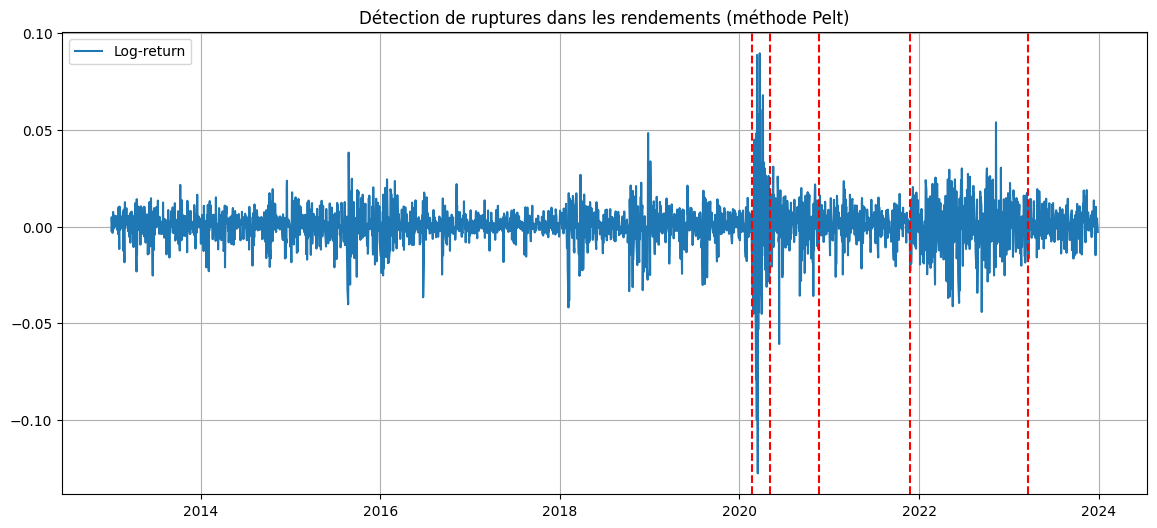

In [17]:
# We choose to analyze log returns but give another option after

signal = data["log_return"].values
# Option 2 : Mobile Vol (rolling std over 20 days)
#signal = data["log_return"].rolling(window=20).std().dropna().values

#We use method Pelt and loss rbf
'''algo = rpt.Pelt(model="rbf").fit(signal)
breakpoints = algo.predict(pen=10)'''

# Option 2 : We can also force a number of rupture points but need to use another model than Pelt
algo = rpt.Binseg(model="rbf").fit(signal)
breakpoints = algo.predict(n_bkps=5)  

plt.figure(figsize=(14, 6))
plt.plot(data.index, signal, label="Log-return")
for bkpt in breakpoints:
    if bkpt < len(data):
        plt.axvline(data.index[bkpt], color='red', linestyle='--')
plt.title("Détection de ruptures dans les rendements (méthode Pelt)")
plt.grid(True)
plt.legend()
plt.show()


# 5. Comparison of HMM and Ruptures

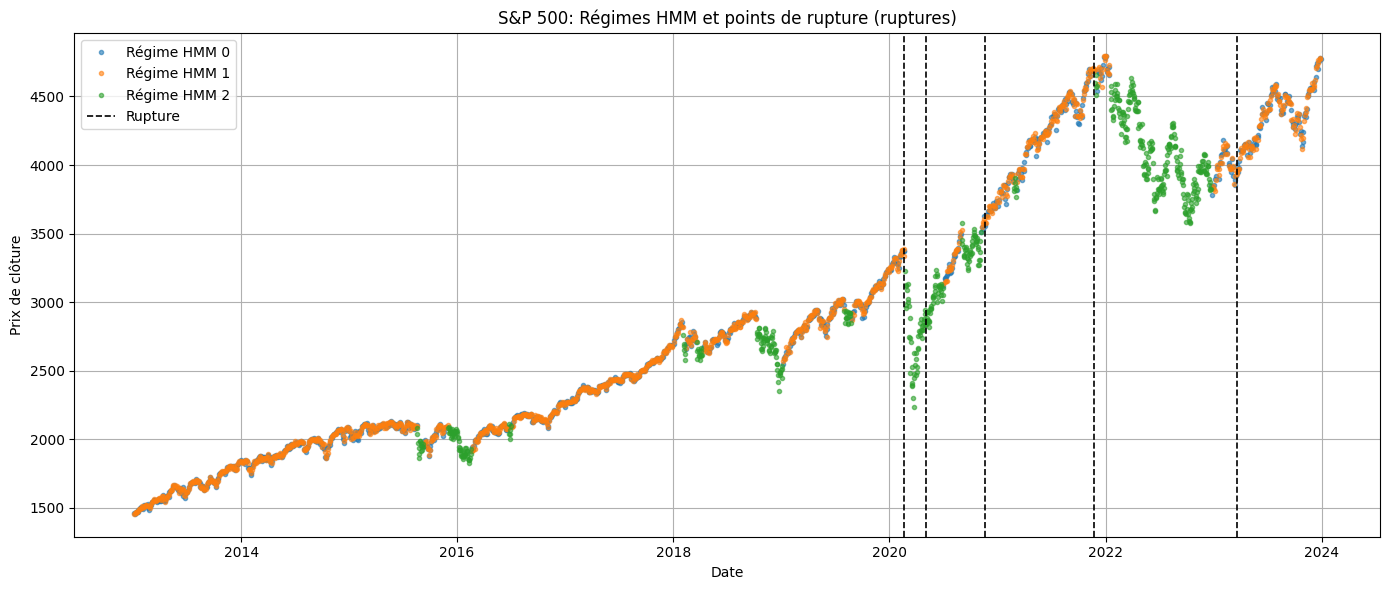

In [ ]:
plt.figure(figsize=(14, 6))

for i in range(n_states):
    state = data[data["regime"] == i]
    plt.plot(state.index, state["price"], '.', label=f"Régime HMM {i}", alpha=0.6)

for bkpt in breakpoints:
    if bkpt < len(data):
        plt.axvline(data.index[bkpt], color="black", linestyle="--", linewidth=1.2, label="Rupture" if bkpt == breakpoints[0] else None)

plt.title("S&P 500: Régimes HMM et points de rupture (ruptures)")
plt.xlabel("Date")
plt.ylabel("Prix de clôture")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# 6. Analysis of features to better understand the HMM regimes

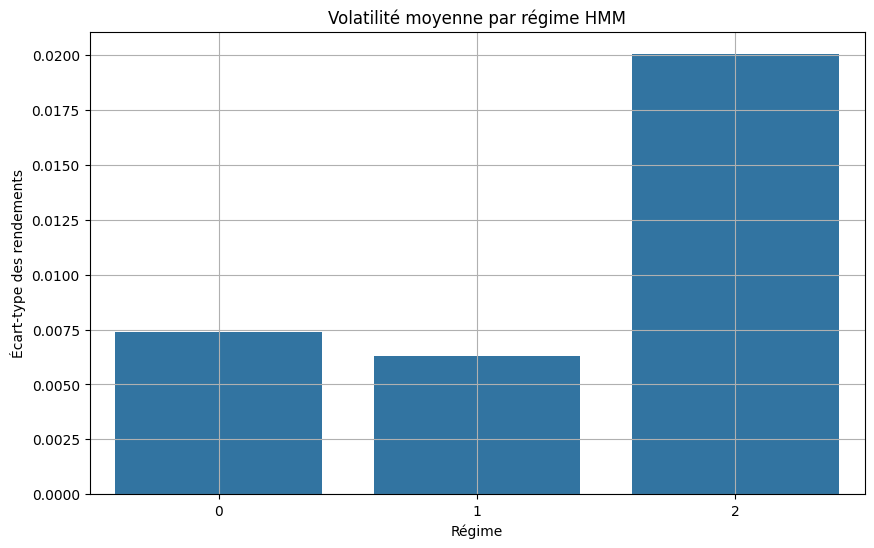

,regime,count,mean,std (volatility),skew,kurtosis
0,1,1110,0.001353,0.006280,-0.053112,0.543575
1,0,1106,0.000400,0.007398,-0.318854,0.942829
2,2,551,-0.001383,0.020041,-0.382658,5.168180


In [24]:
features = []

for i in range(n_states):
    subset = data[data["regime"] == i]["log_return"]
    stats = {
        "regime": i,
        "count": len(subset),
        "mean": subset.mean(),
        "std (volatility)": subset.std(),
        "skew": skew(subset),
        "kurtosis": kurtosis(subset),
    }
    features.append(stats)

features_df = pd.DataFrame(features).sort_values(by="std (volatility)", ascending=True)
features_df.reset_index(drop=True, inplace=True)

plt.figure(figsize=(10, 6))
sns.barplot(data=features_df, x="regime", y="std (volatility)")
plt.title("Volatilité moyenne par régime HMM")
plt.ylabel("Écart-type des rendements")
plt.xlabel("Régime")
plt.grid(True)
plt.show()

display(features_df)
